#  Pre-trained network
### There are two ways to leverage a pre-trained network: feature extraction and fine-tuning

In [1]:
from tensorflow.keras.applications import VGG16

In [2]:
conv_base = VGG16(weights='imagenet',
 include_top=False,
 input_shape=(150, 150, 3))

In [3]:
 conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Feature extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye")

Two ways to proceed:
* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

* Extending the pre trained model by adding dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

## Extracting features using the pre-trained convolutional base

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = 'C:/Users/camil/OneDrive/Escritorio/AIcursos/Tensorflow/CNN/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
# flatten
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [8]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 3s 25ms/step - loss: 0.6071 - acc: 0.6740 - val_loss: 0.4412 - val_acc: 0.8470
Epoch 2/30
100/100 [==============================] - 2s 22ms/step - loss: 0.4495 - acc: 0.7915 - val_loss: 0.3647 - val_acc: 0.8650
Epoch 3/30
100/100 [==============================] - 2s 23ms/step - loss: 0.3594 - acc: 0.8470 - val_loss: 0.3237 - val_acc: 0.8850
Epoch 4/30
100/100 [==============================] - 2s 23ms/step - loss: 0.3215 - acc: 0.8755 - val_loss: 0.2991 - val_acc: 0.8910
Epoch 5/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2848 - acc: 0.8850 - val_loss: 0.2855 - val_acc: 0.8990
Epoch 6/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2708 - acc: 0.8920 - val_loss: 0.2744 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2489 - acc: 0.9020 - val_loss: 0.2649 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 2s 23ms/step - 

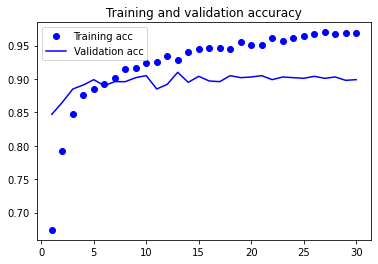

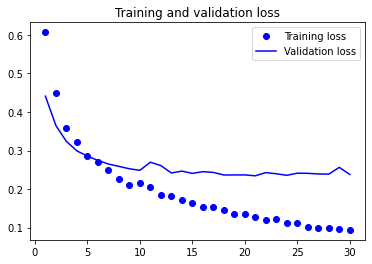

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# It's posible to see an overfitting since the start->This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

## Adding a densely-connected classifier on top of the convolutional base

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [11]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
 rescale=1./255,
 rotation_range=40,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True,
 fill_mode='nearest')

 # Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
 # This is the target directory
 train_dir,
 # All images will be resized to 150x150
 target_size=(150, 150),
 batch_size=20,
 # Since we use binary_crossentropy loss, we need binary labels
 class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
 validation_dir,
 target_size=(150, 150),
 batch_size=20,
 class_mode='binary')
model.compile(loss='binary_crossentropy',
 optimizer=optimizers.RMSprop(lr=2e-5),
 metrics=['acc'])
history = model.fit_generator(
 train_generator,
 steps_per_epoch=100,
 epochs=30,
 validation_data=validation_generator,
 validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 236s 2s/step - loss: 0.5870 - acc: 0.6955 - val_loss: 0.4699 - val_acc: 0.7860
Epoch 2/30
100/100 [==============================] - 251s 3s/step - loss: 0.4807 - acc: 0.7800 - val_loss: 0.3754 - val_acc: 0.8470
Epoch 3/30
100/100 [==============================] - 247s 2s/step - loss: 0.4399 - acc: 0.8005 - val_loss: 0.3434 - val_acc: 0.8630
Epoch 4/30
100/100 [==============================] - 248s 2s/step - loss: 0.4017 - acc: 0.8195 - val_loss: 0.3149 - val_acc: 0.8670
Epoch 5/30
100/100 [==============================] - 252s 3s/step - loss: 0.3805 - acc: 0.8320 - val_loss: 0.3457 - val_acc: 0.8410
Epoch 6/30
100/100 [==============================] - 253s 3s/step - loss: 0.3819 - acc: 0.8230 - val_loss: 0.2971 - val_acc: 0.8750
Epoch 7/30
100/100 [======================

KeyboardInterrupt: 